# Toy model for estimation of connectivity in MOU process

This Python notebook estimates the connectivity matrix from the observed activity generated by a MOU process.

In [1]:
import os
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt
from pymou import MOU
import pymou.tools as tools
import matplotlib.pyplot as pp

## Simulation

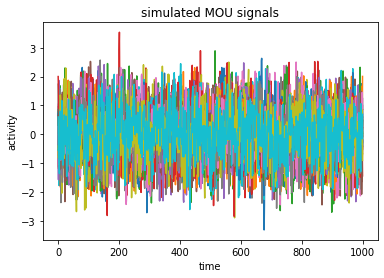

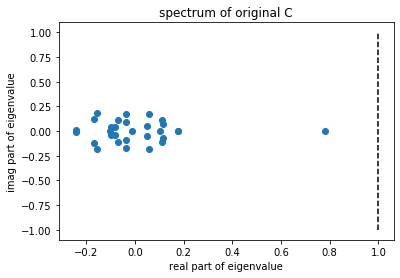

In [2]:
N = 30 # number of nodes
d = 0.3 # density of connectivity
# generate random matrix
C_orig = tools.make_rnd_connectivity(N, density=d, w_min=0.5/N/d, w_max=1.0/N/d)

# create MOU process
mou_orig = MOU(C_orig)

T = 1000 # time in seconds
# simulate
ts_sim = mou_orig.simulate(T)

# plots
pp.figure()
pp.plot(range(T),ts_sim)
pp.xlabel('time')
pp.ylabel('activity')
pp.title('simulated MOU signals')

D = np.linalg.eigvals(C_orig)
pp.figure()
pp.scatter(np.real(D),np.imag(D))
pp.plot([1,1],[-1,1],'--k')
pp.xlabel('real part of eigenvalue')
pp.ylabel('imag part of eigenvalue')
pp.title('spectrum of original C')

pp.show()

In [ ]:
Q_sim = np.tensordot(ts_sim,ts_sim,axes=(0,0)) / (T-1)

J = -np.eye(N) + C_orig
Sigma = np.eye(N)
Q_th = spl.solve_continuous_lyapunov(J,-Sigma)


# plots
pp.figure()
pp.imshow(Q_sim)
pp.colorbar()
pp.xlabel('target ROI')
pp.ylabel('source ROI')
pp.title('covariance matrix (functional connectivity)')

pp.figure()
pp.plot([0,Q_th.max()],[0,Q_th.max()],'--k')
pp.plot(Q_sim,Q_th,'.b')
pp.xlabel('simulated covariances')
pp.ylabel('theoretical covariances')

pp.show()

## Connectivity estimation

In [ ]:
# Lyapunov optimization
mou_est = MOU()
if True:
    # estimate of weights without knowledge of the topology of existing weights in C_orig
    # regularization may be helpful here to "push" small weights to zero here
    mou_est.fit(ts_sim, i_tau_opt=1, regul_C=1.)
else:
    # estimate of weights knowing the topology of existing weights in C_orig
    mou_est.fit(ts_sim, i_tau_opt=1, mask_C=C_orig>0)

C_est = mou_est.get_C()


# plots
pp.figure()
pp.imshow(C_orig,vmin=0)
pp.colorbar()
pp.xlabel('target ROI')
pp.ylabel('source ROI')
pp.title('original connectivity')

pp.figure()
pp.imshow(C_est,vmin=0)
pp.colorbar()
pp.xlabel('target ROI')
pp.ylabel('source ROI')
pp.title('estimated connectivity')

pp.figure()
pp.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
pp.plot(C_est,C_orig,'xr')
pp.xlabel('estimated connectivity')
pp.ylabel('original connectivity')

pp.show()

In [ ]:
# moments method
mou_est2 = MOU()
mou_est2.fit(ts_sim,method='moments')

C_est2 = mou_est2.get_C()


# plots
pp.figure()
pp.imshow(C_orig,vmin=0)
pp.colorbar()
pp.xlabel('target ROI')
pp.ylabel('source ROI')
pp.title('original connectivity')

pp.figure()
pp.imshow(C_est2,vmin=0)
pp.colorbar()
pp.xlabel('target ROI')
pp.ylabel('source ROI')
pp.title('estimated connectivity')

pp.figure()
pp.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
pp.plot(C_est2,C_orig,'xr')
pp.xlabel('estimated connectivity')
pp.ylabel('original connectivity')

pp.show()

In [ ]:
print('model fit for Lyapunov:',mou_est.d_fit['correlation'])
print('model fit for moments:',mou_est2.d_fit['correlation'])

print('C_orig fit for Lyapunov',stt.pearsonr(C_orig.flatten(),C_est.flatten()))
print('C_orig fit for moments',stt.pearsonr(C_orig.flatten(),C_est2.flatten()))
print('C_orig fit for moments + positive constraints',stt.pearsonr(C_orig.flatten(),np.maximum(C_est2,0).flatten()))

min_weight = min(C_est.min(),C_est2.min())
max_weight = max(C_est.max(),C_est2.max())
bins = np.linspace(min_weight,max_weight,40)

pp.figure()
pp.subplot(211)
pp.hist(C_est[C_orig>0], bins=bins, histtype='step', color='g')
pp.hist(C_est[C_orig==0], bins=bins, histtype='step', color='k')
pp.ylabel('distributions estimates')
pp.title('green = true; black = false')
pp.subplot(212)
pp.hist(C_est2[C_orig>0], bins=bins, histtype='step', color='g')
pp.hist(C_est2[C_orig==0], bins=bins, histtype='step', color='k')
pp.ylabel('distributions estimates')

pp.figure()
pp.subplot(211)
pp.hist(C_est[C_orig>0], bins=bins, histtype='step', cumulative=True, density=True, color='g')
pp.hist(C_est[C_orig==0], bins=bins, histtype='step', cumulative=True, density=True, color='k')
pp.ylabel('cumulative density')
pp.title('green = true; black = false')
pp.subplot(212)
pp.hist(C_est2[C_orig>0], bins=bins, histtype='step', cumulative=True, density=True, color='g')
pp.hist(C_est2[C_orig==0], bins=bins, histtype='step', cumulative=True, density=True, color='k')
pp.ylabel('cumulative density')

pp.figure()
pp.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
pp.plot(C_est,C_est2,'xr')
pp.xlabel('LO estimate')
pp.ylabel('moment estimate')

pp.show()